In [1]:
%matplotlib inline

from preprocess import *
from utils import *
import TemporalClusterer as tc
import numpy as np
import pandas as pd
import datetime

import umap
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.cluster.hierarchy import dendrogram, linkage

import sys
import os

%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})
thresh=10
act_threshold=4
aggr=15*60

In [3]:
file_list = [x.date().isoformat() for x in pd.date_range('2020-01-25', '2020-01-31')]
days = len(file_list)

df = pd.DataFrame()
for file_name in file_list:
    df = pd.concat([df, pd.read_pickle('../../data/' + file_name + '.pcl')], ignore_index=True)

df.head()

,ip,timestamp,origin,type,line
0,200.195.174.226,1579906758,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",0
1,158.69.228.47,1579906761,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",567
2,185.209.0.109,1579906764,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",1164
3,222.186.175.23,1579906765,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",1762
4,167.86.110.219,1579906764,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",2329


In [4]:
tfrom = datetime.datetime.fromisoformat('{} 00:00:00'.format(file_list[0])).timestamp()
tto = datetime.datetime.fromisoformat('{} 23:59:59'.format(file_list[-1])).timestamp()

df = df.loc[(df['timestamp'] >= tfrom) & (df['timestamp'] < tto), :]
df['slot']= ((df['timestamp']-tfrom)/aggr).astype(np.int)

df.head()

,ip,timestamp,origin,type,line,slot
52,5.182.39.96,1579910396,[{'SW': ['Cowrie with Warden Filer output modu...,"['Test', 'Intrusion.UserCompromise']",61080,3
53,5.188.86.165,1579910397,[{'SW': ['Cowrie with Warden Filer output modu...,"['Test', 'Intrusion.UserCompromise']",61574,3
54,5.188.62.13,1579910397,[{'SW': ['Cowrie with Warden Filer output modu...,"['Test', 'Intrusion.UserCompromise']",62069,3
151,5.188.87.60,1579910401,[{'SW': ['Cowrie with Warden Filer output modu...,"['Test', 'Intrusion.UserCompromise']",129601,4
152,5.188.86.165,1579910401,[{'SW': ['Cowrie with Warden Filer output modu...,"['Test', 'Intrusion.UserCompromise']",130095,4


In [5]:
dfip = pd.DataFrame()
dfip['list'] = df.groupby('ip')['slot'].agg(lambda x: (list(x)))
dfip['count'] = dfip.list.apply(list.__len__)

#mark out low tail... and if to analyze them, do it separately
dfip['class'] = (dfip['count'] > thresh)

dfip.head()

,list,count,class
ip,,,
1.0.0.24,"[44, 278, 332, 334, 417, 483, 602]",7,False
1.0.118.130,"[7, 8, 9, 14, 16, 17, 18, 19, 22, 23, 24, 25, ...",249,True
1.0.123.199,[384],1,False
1.0.128.98,[454],1,False
1.0.130.219,"[56, 57]",2,False


IP count reduction when event threshold is set to 10
 ratio 0.22425852332880108
 ip count 128155


C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\matplotlib\mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


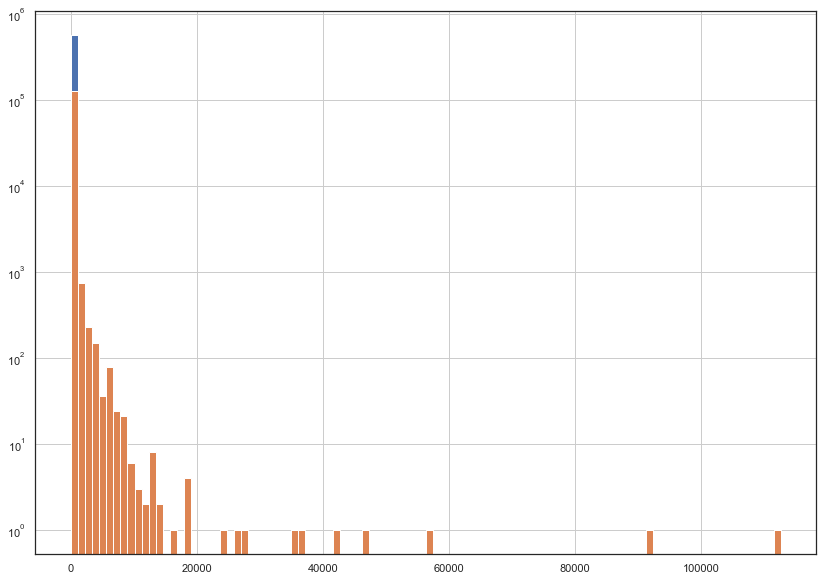

In [6]:
plt.figure()
dfip['count'].hist(bins=100)
plt.yscale('log')
dfip.loc[dfip['count']>thresh,'count'].hist(bins=100)


print("IP count reduction when event threshold is set to {}\n ratio {}\n ip count {}"
      .format(thresh, 
              len(dfip.loc[dfip['count']>thresh, 'count'])/len(dfip['count']),
              len(dfip.loc[dfip['count']>thresh])))


In [7]:
dfip['list'] = df.groupby('ip')['slot'].agg(lambda x: list(x))

dfip['series'] = dfip['list'].apply(get_bin_series, args=[np.ceil((days*24*3600)/aggr)]) 
                               
dfip['activity'] = dfip['series'].apply(lambda x: np.sum(x))

IP count reduction when activity threshold is set to 4
 ratio 0.35426039572254275
 ip count 202446


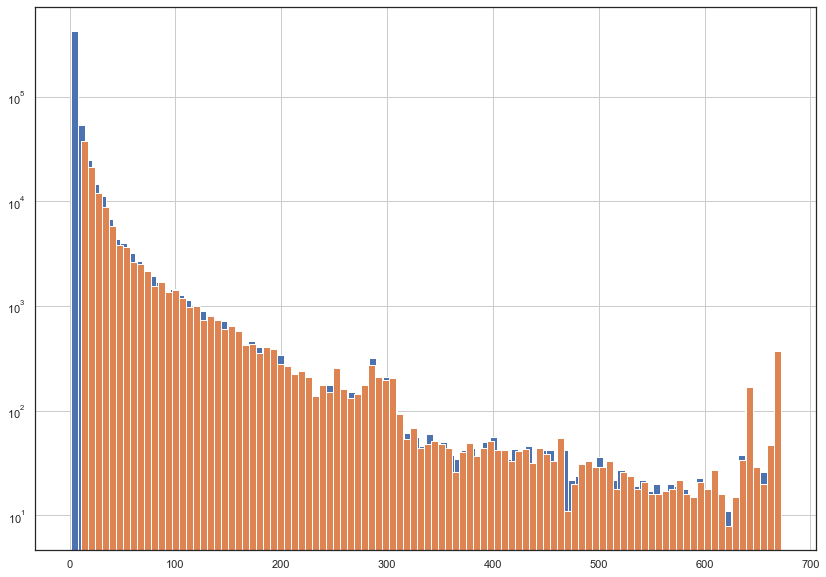

In [8]:
plt.figure()
dfip['activity'].hist(bins=100)
plt.yscale('log')
dfip.loc[dfip['activity']>thresh,'activity'].hist(bins=100)

act_threshold=4
print("IP count reduction when activity threshold is set to {}\n ratio {}\n ip count {}"
      .format(act_threshold, 
              len(dfip.loc[dfip['activity']>act_threshold, 'activity'])/len(dfip['activity']),
              len(dfip.loc[dfip['activity']>act_threshold])))

In [9]:
act = pd.DataFrame(data=np.stack(dfip['series']), index=dfip.index)
act.head()

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
ip,,,,,,,,,,,,,,,,,,,,,
1.0.0.24,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1.0.118.130,False,False,False,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1.0.123.199,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1.0.128.98,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1.0.130.219,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


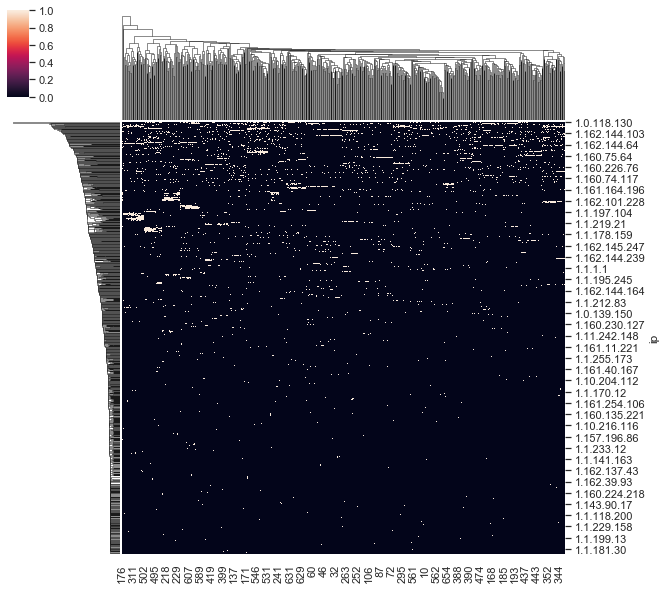

In [10]:
sns.clustermap(act.head(1000))

In [11]:
act['ip']=act.index
exmatch=act.groupby(list(range(0,np.int((days*24*3600)/aggr)))).agg(list)
print(len(exmatch)/len(act))

0.5020657577682467


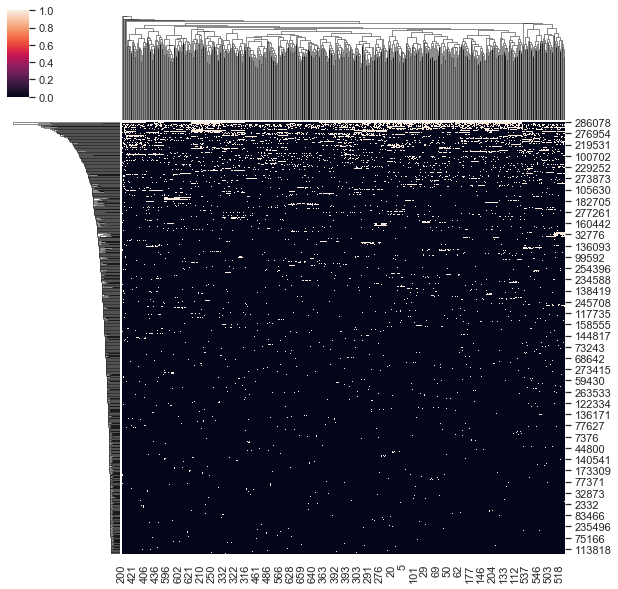

In [12]:
test = pd.DataFrame(data=np.stack(exmatch.index.to_flat_index()), index=exmatch[:])
#test.head()

ctest=test
ctest.index=range(0,len(ctest))
cg=sns.clustermap(ctest.sample(1000))

groups = pd.DataFrame(data=exmatch.values)
groups['size'] = groups.apply(lambda x: len(x[0]), axis=1)

groups.index=groups[0].apply(lambda x: x[0])
groups['activity']=dfip['activity']

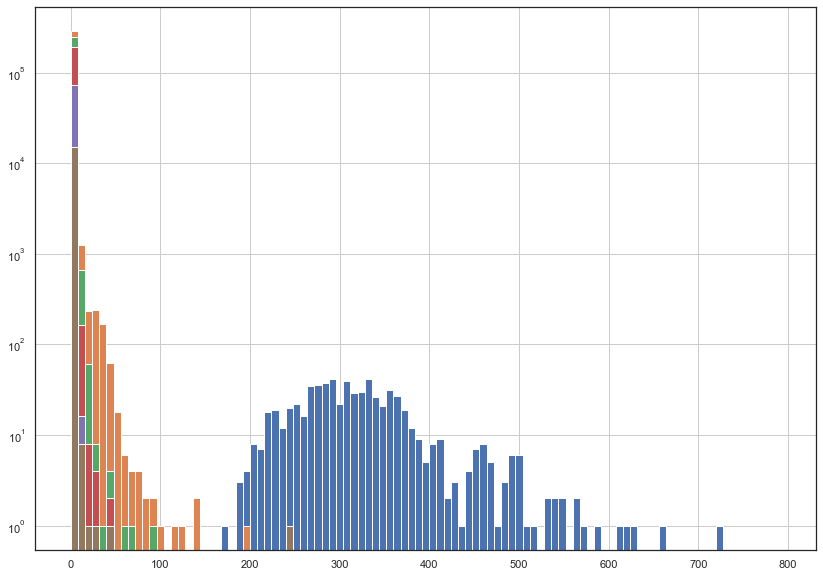

In [13]:
groups['size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>1, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>2, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>act_threshold, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>20, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>100, 'size'].hist(bins=list(range(0,800,8)))

#groups.loc[(groups['activity']>act_threshold)&(groups['size']>15), 'size'].hist(bins=list(range(0,800,8)))

plt.yscale('log')

Predošlý graf je zaujímavý. Ukazuje, ako sa lýšia veľkosti klastrov (presné zhody) a ich rozloženie. 
Ak sa okrem veľkosti grafov vezme do úvahy aj minimálna aktivita (náhodnosť klesá), vidno rozkol v distribúcií.

Pravdepodobne, nízka miera aktivity vedie na veľké množstvo náhodných korelácií, veľké skupiny (modrá)
Artefakty ? Ako by mohli vyzerať ? Ako filtrovať ? 
Graf je dekomponavaný podľa aktivity (počet slotov kde sa komnunikovalo)

modré su náhodné korelácie (x je počet v skupine s presnou zhodou)
Rationale - s počtom slotov aktivity rastie priestor v kt. sa IP môzu rozprestireť, pst. náhodnej korelacie klesá. 
!!!

In [14]:
act['ip']=act.index
act = act.loc[dfip['count']>1]
exmatch=act.groupby(list(range(0,np.int((days*24*3600)/aggr)))).agg(list)
print(len(exmatch)/len(act))

test = pd.DataFrame(data=np.stack(exmatch.index.to_flat_index()), index=exmatch[:])
#test.head()

groups = pd.DataFrame(data=exmatch.values)
groups['size'] = groups.apply(lambda x: len(x[0]), axis=1)

groups.index=groups[0].apply(lambda x: x[0])
groups['activity']=dfip['activity']

0.7990302564445335


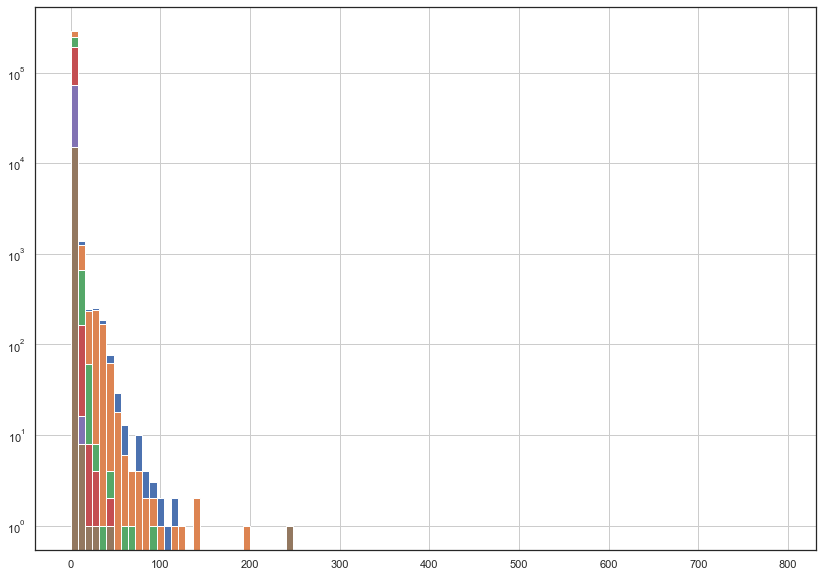

In [15]:
groups['size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>1, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>2, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>act_threshold, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>20, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>100, 'size'].hist(bins=list(range(0,800,8)))

#groups.loc[(groups['activity']>act_threshold)&(groups['size']>15), 'size'].hist(bins=list(range(0,800,8)))

plt.yscale('log')

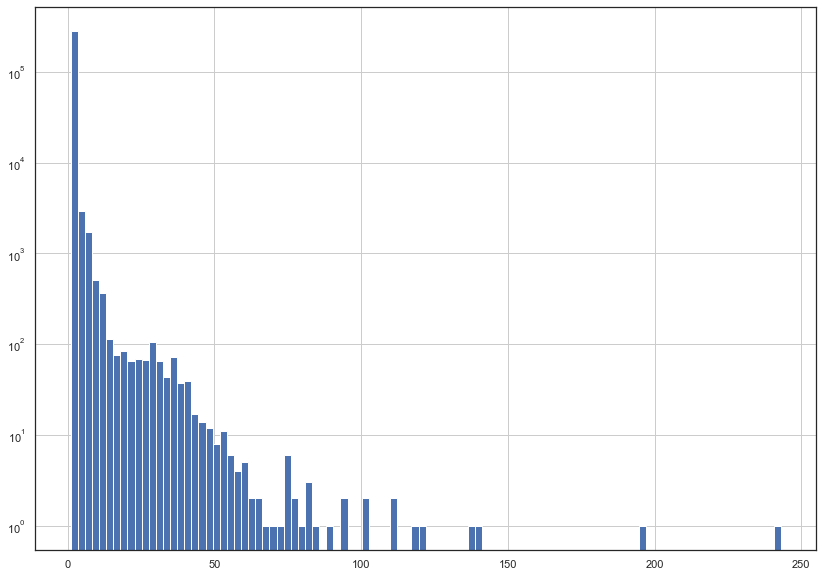

In [16]:
groups['size'].hist(bins=100)
plt.yscale('log')

In [17]:
gseries = pd.DataFrame()
gseries['list'] = dfip.loc[groups.index,'list'].copy()

print(gseries.head())
print(gseries.size)
#TODO - finish this!
#Set division to close to independant components
#Now loop through
gseries['ip'] = (gseries.index)
gseries.index = gseries.ip.values
filt=gseries.groupby('ip').agg('count')
gseries = gseries.loc[filt>1,:]

MX = np.int((tto-tfrom)/(aggr*4))

gseries['slot4'] = gseries['list'].apply(lambda x: np.divide(x,MX).astype(np.int))
print(gseries.head())
print(MX)

                                list
0                                   
159.89.162.177  [671, 671, 671, 671]
139.28.218.45             [670, 670]
13.211.51.36         [670, 671, 671]
124.122.26.168            [669, 669]
118.173.70.222            [669, 671]
286903


ValueError: Cannot index with multidimensional key

In [ ]:
gby = pd.DataFrame(data=np.stack(gseries['slot4'].apply(get_bin_series, args=[4+1])), index=gseries['ip'])
gby['ip'] = gseries['ip']
a=gby.groupby(list(range(0,np.int(4+1)))).agg('count')
print(a)

In [ ]:
gseries['slot8'] = gseries['list'].apply(lambda x: np.divide(x,MX/2).astype(np.int))
gby = pd.DataFrame(data=np.stack(gseries['slot8'].apply(get_bin_series, args=[2*4+1])), index=gseries['ip'])
gby['ip'] = gseries['ip']
a=gby.groupby(list(range(0,np.int(2*4+1)))).agg('count')
print(a)


In [ ]:
d = act.loc[dfip['activity']>10,:].iloc[:30000,0:-1]

embedding = umap.UMAP(n_components=4).fit_transform(d)
sns.pairplot(data=embedding)

In [ ]:

g = sns.PairGrid(pd.DataFrame(embedding))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

In [ ]:
d.shape

In [ ]:
len(dfip['activity']>10)
dfip.loc[dfip['activity']>10,'activity'].hist(bins=100)
print(dfip.loc[dfip['activity']>10,'activity'].shape)

In [ ]:
d.loc[dfip['activity']>10,:].to_csv('./15minmat.csv')
